In [1]:
!pip install pytorch-lightning
!pip install transformers[torch]
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.6 MB/s eta 0:00:00


# Import lib

In [56]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
import time
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import re
import copy
import nltk
from nltk.tokenize import word_tokenize
import math
from torchinfo import summary
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Clone dataset

In [3]:
! git clone https://github.com/duongnghia222/News_classification

Cloning into 'News_classification'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 479 (delta 40), reused 77 (delta 40), pack-reused 402
Receiving objects: 100% (479/479), 110.96 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (278/278), done.
Updating files: 100% (56/56), done.


# Load dataset

In [4]:
# Load data from CSV file
df = pd.read_csv('News_classification/data/raw_data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

## Show data structure

In [5]:
df.tail()

,Content,Label
10395,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10396,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10397,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10398,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10399,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


## Add Word Count and Class Count Column

In [6]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10400.000000
mean       607.838942
std        352.154704
min         46.000000
25%        381.000000
50%        514.000000
75%        726.250000
max       4235.000000
Name: Word Count, dtype: float64

In [7]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


## Word Count Histogram

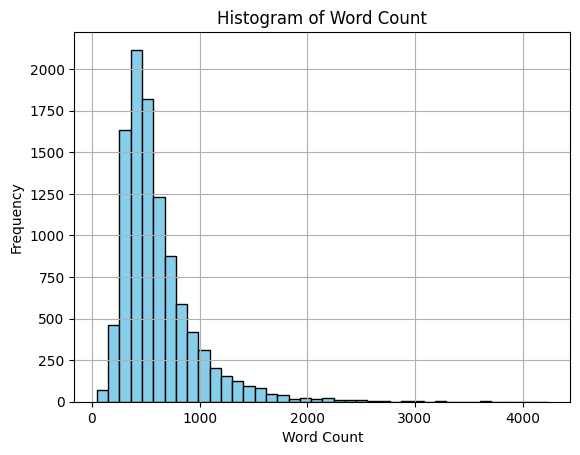

In [8]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
label_counts = df['Label'].value_counts()
print(label_counts.describe())

count    938.000000
mean      11.087420
std       21.018334
min        1.000000
25%        1.000000
50%        3.000000
75%       10.750000
max      197.000000
Name: Label, dtype: float64


# Extract Dataset

In [10]:
# extracted_df
e_df = df.loc[df['Class Count'] > 17].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        7220
Label          7220
Word Count     7220
Class Count    7220
dtype: int64

In [11]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

156

# Processing Dataset

## Clean text

In [12]:
with open('/content/News_classification/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [13]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [14]:
# e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count
3945,Hòa Phát tiêu thụ thép xây dựng tăng 82%. Tron...,HPG,324,197
1809,Công ty Container Hòa Phát bị phạt hành chính ...,HPG,1053,197
7422,Sản lượng bán thép tháng 10 của Hòa Phát giảm ...,HPG,346,197
943,'Lão tướng' sáng lập FPT gọi Hoà Phát là... kỳ...,HPG,1035,197
2267,Cổ đông Hòa Phát quan tâm gì trước ngày đại hộ...,HPG,1271,197


## Transform labels

In [15]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [16]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[142, 142, 101, 142, 31, 31, 73, 73, 31, 31]


In [17]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
3945,Hòa Phát tiêu thụ thép xây dựng tăng 82%. Tron...,HPG,324,197,55
1809,Công ty Container Hòa Phát bị phạt hành chính ...,HPG,1053,197,55
7422,Sản lượng bán thép tháng 10 của Hòa Phát giảm ...,HPG,346,197,55
943,'Lão tướng' sáng lập FPT gọi Hoà Phát là... kỳ...,HPG,1035,197,55
2267,Cổ đông Hòa Phát quan tâm gì trước ngày đại hộ...,HPG,1271,197,55
2111,Hòa Phát quý III: Chi phí tài chính hơn 2.300 ...,HPG,693,197,55
5448,"Nhà máy Dung Quất đi vào hoạt động, Hòa Phát t...",HPG,1331,197,55
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197,55
5405,Hòa Phát sản xuất container: Những bài toán đã...,HPG,1784,197,55
2669,"Hòa Phát có thêm 18.000 cổ đông sau một năm, H...",HPG,720,197,55


## Split trainset valset

In [18]:
trainset, valset = train_test_split(e_df, test_size=0.2, stratify=e_df['Encode Label'])
print(len(trainset))
trainset = trainset.drop_duplicates(subset=['Label', 'Word Count'], keep='first')
print(len(trainset))
trainset['Class Count'] = trainset.groupby('Label')['Label'].transform('count')
valset['Class Count'] = valset.groupby('Label')['Label'].transform('count')
print("How many unique labels in the trainset", trainset['Encode Label'].nunique())
print("How many unique labels in the valset", valset['Encode Label'].nunique())

5776
5451
How many unique labels in the trainset 156
How many unique labels in the valset 156


<ipython-input-18-00e196e67d09>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainset['Class Count'] = trainset.groupby('Label')['Label'].transform('count')


# Visualize Extracted Data

In [19]:
trainset_unique_label = trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")
trainset_unique_label.head()

,Content,Label,Word Count,Class Count,Encode Label
2696,OCH muốn xóa gần 853 tỷ đồng nợ xấu khỏi bảng ...,OCH,867,13,90
3786,TCT Phong Phú: Cánh chim đầu đàn của ngành dệt...,VGT,1644,13,142
2364,Thêm 4.300 tỷ đồng về khu đô thị tỷ USD ở khu ...,TCB,450,13,123
5675,"SSI phê duyệt hạn mức tín dụng 10,400 tỷ đồng ...",SSI,214,14,119
7006,"Pomina lỗ kỷ lục 716 tỷ đồng, nợ vay 5.5 ngàn ...",POM,575,14,101


## Class Distribution Histogram

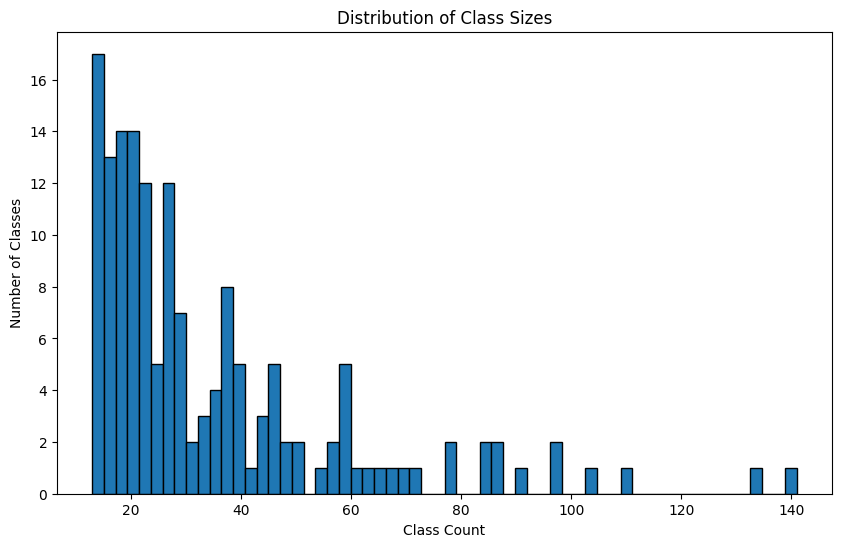

In [20]:
plt.figure(figsize=(10,6))
plt.hist(trainset_unique_label['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()


## Class Distribution PieChart

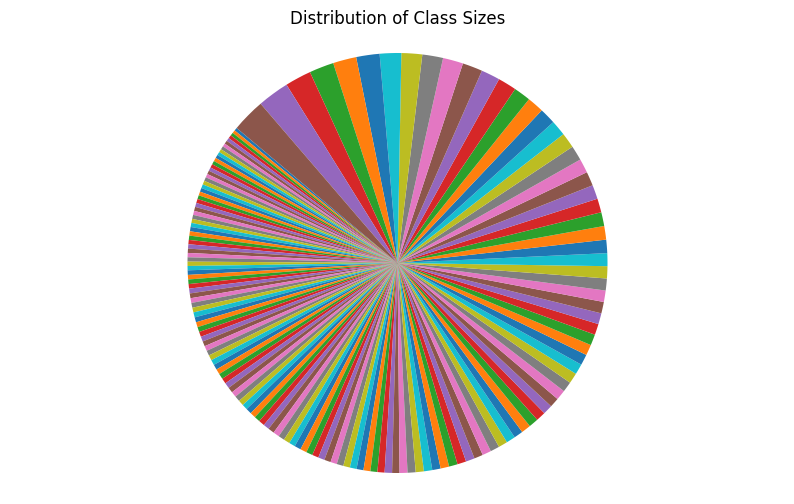

In [21]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = trainset_unique_label['Class Count'].values

plt.figure(figsize=(10,6))
plt.pie(sizes, startangle=140)
plt.title('Distribution of Class Sizes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Balance Dataset

In [22]:
def balance_data(df, target_count, max_length):
    balanced_df = pd.DataFrame(columns=df.columns)
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        count = len(label_df)

        if count >= target_count:
            label_df = label_df.sample(n=target_count, random_state=42)
        else:
            additional_samples_needed = target_count - count
            samples_per_row = (additional_samples_needed // count) + 1
            additional_samples = []

            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)

                window_start = 0

                for _ in range(samples_per_row):
                    picked_sentences = []
                    word_count = 0
                    i = window_start  # Set i to the start of the current window

                    while i < len(sentences):
                        sentence = sentences[i]
                        sentence_word_count = len(sentence.split())

                        if word_count + sentence_word_count > max_length:
                            break

                        picked_sentences.append(sentence)
                        word_count += sentence_word_count
                        i += 1

                    # No need to remove picked sentences from the list

                    if len(picked_sentences) > 0:
                        new_sample = pd.Series(data=copy.deepcopy(row.values), index=df.columns)
                        new_sample['Content'] = ' '.join(picked_sentences)
                        new_sample['Word Count'] = len(new_sample['Content'].split())
                        if new_sample['Word Count'] <= max_length:
                            additional_samples.append(new_sample)

                    # Slide the window by one sentence
                    if window_start + 1 < len(sentences):
                        window_start += 1
                    else:
                        break  # Break the loop if we've processed all sentences

            # This is a new block of code to limit the number of samples
            # We randomly select 'target_count' samples if there are more than 'target_count' samples
            if len(additional_samples) + count > target_count:
                additional_samples = random.sample(additional_samples, target_count - count)

            additional_samples = pd.DataFrame(additional_samples)
            label_df = pd.concat([label_df, additional_samples], ignore_index=True)

        balanced_df = pd.concat([balanced_df, label_df], ignore_index=True)

    return balanced_df


In [23]:
balanced_trainset = balance_data(trainset, target_count=50, max_length=150)

In [24]:
balanced_trainset['Class Count'] = balanced_trainset.groupby('Label')['Label'].transform('count')
print("How many unique labels in the trainset", balanced_trainset['Encode Label'].nunique())
# df['Word Count'] = balanced_trainset['Content'].apply(lambda x: len(str(x).split()))
balanced_trainset.head()

How many unique labels in the trainset 156


,Content,Label,Word Count,Class Count,Encode Label
0,PNJ sắp phát hành cổ phiếu thưởng tỉ lệ 33%. P...,PNJ,442,50,100
1,"PNJ lãi 859 tỷ sau 4 tháng, đạt 44% kế hoạch n...",PNJ,709,50,100
2,"Sức mua tiếp tục suy yếu, lợi nhuận PNJ ...",PNJ,500,50,100
3,"Doanh thu tăng mạnh, PNJ báo lãi tháng 7 gần 8...",PNJ,441,50,100
4,Lãnh đạo PNJ: Đặt mục tiêu 500 cửa hàng đến nă...,PNJ,1010,50,100


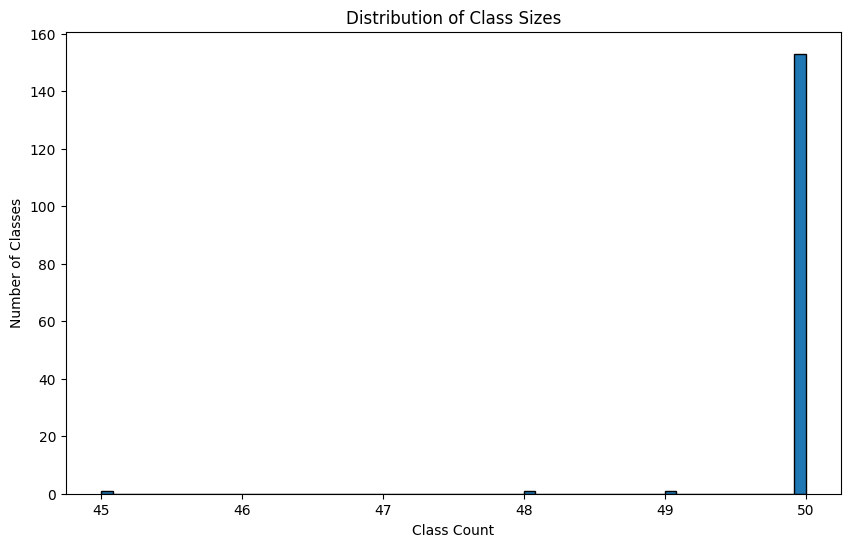

In [25]:
plt.figure(figsize=(10,6))
plt.hist(balanced_trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()

In [26]:
balanced_trainset[balanced_trainset['Encode Label'] == random.randint(0, number_of_classes)].sort_values(by="Word Count").head()

,Content,Label,Word Count,Class Count,Encode Label
284,"Thị giá rớt mạnh, CII chỉ bán được 8% cổ phiếu...",CII,294,50,16
292,"CII giảm tỷ lệ cổ tức năm 2020 xuống còn 14%, ...",CII,297,50,16
251,Tổng giám đốc CII làm phó chủ tịch HĐQT của Nă...,CII,306,50,16
275,CII sắp phát hành gần 34 triệu cổ phiếu trả cổ...,CII,317,50,16
258,CII muốn đầu tư vào một doanh nghiệp niêm yết....,CII,326,50,16


# Load phoBERT tokenizer

In [27]:
checkpoint_model = 'vinai/phobert-base-v2'

In [28]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_model, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [29]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [30]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
LR = 5e-5
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 100

# ArticleDataset Class

In [31]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'content': item.Content,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



# Pytorch Lightning DataLoader

In [32]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch-lightning DataLoader

In [33]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(balanced_trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
print("number of batches in an epoch: ", len(data_loader.train_dataloader()))

number of batches in an epoch:  244


# Model architecture

In [34]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.bert = AutoModelForSequenceClassification.from_pretrained('vinai/phobert-base-v2', num_labels=number_of_classes)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask).logits
        return x

# Initialize Model

## Model configuration

In [35]:
config = {
    'model_name': checkpoint_model,
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': LR,
    'warmup': 0.15,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.01,
    'n_epochs': EPOCHS,
    'early_stopping_limit': 3
}

## Create model

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
# Initialize our classifier
model = ArticleClassifier(config)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weig

# Model Summary

In [38]:
summary(model)

Layer (type:depth-idx)                                            Param #
ArticleClassifier                                                 --
├─RobertaForSequenceClassification: 1-1                           --
│    └─RobertaModel: 2-1                                          --
│    │    └─RobertaEmbeddings: 3-1                                49,353,216
│    │    └─RobertaEncoder: 3-2                                   85,054,464
│    └─RobertaClassificationHead: 2-2                             --
│    │    └─Linear: 3-3                                           590,592
│    │    └─Dropout: 3-4                                          --
│    │    └─Linear: 3-5                                           119,964
├─CrossEntropyLoss: 1-2                                           --
Total params: 135,118,236
Trainable params: 135,118,236
Non-trainable params: 0


# Train Model

In [39]:
def train_model(model, data_loader, config, model_path=None):
    if model_path is not None:
          # Load the pre-trained model
          model.load_state_dict(torch.load(model_path))

    model = model.to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = config['early_stopping_limit']  # Number of epochs with no improvement after which training will be stopped
    save_model_path = 'NPL_news_classification.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        start_time = time.time()  # start time of the epoch

        model.train()
        total_loss = 0

        train_predictions , train_true_labels = [], []

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store train predictions and true labels for accuracy calculation
            train_predictions.append(logits)
            train_true_labels.append(labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Calculate training accuracy
        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_labels = np.concatenate(train_true_labels, axis=0)
        train_accuracy = accuracy_score(train_true_labels, np.argmax(train_predictions, axis=1))

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        end_time = time.time()  # end time of the epoch
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)  # calculate elapsed time for this epoch

        # Print additional information after each epoch
        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% | Valid Loss: {avg_val_loss:.3f} | Valid Acc: {val_accuracy*100:.2f}%')

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy, 'train_acc': train_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model.state_dict(), save_model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [40]:
train_model(model, data_loader, config)

Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 01 | Time: 5.0m 54.712355613708496s
	Train Loss: 4.658 | Train Acc: 48.74% | Valid Loss: 3.825 | Valid Acc: 92.45%

Epoch: 02 | Time: 6.0m 0.47003626823425293s
	Train Loss: 3.422 | Train Acc: 93.38% | Valid Loss: 2.628 | Valid Acc: 94.88%

Epoch: 03 | Time: 6.0m 0.3675720691680908s
	Train Loss: 2.334 | Train Acc: 96.01% | Valid Loss: 1.623 | Valid Acc: 95.36%

Epoch: 04 | Time: 6.0m 0.056105852127075195s
	Train Loss: 1.425 | Train Acc: 97.24% | Valid Loss: 0.951 | Valid Acc: 95.08%

Epoch: 05 | Time: 6.0m 0.13916707038879395s
	Train Loss: 0.808 | Train Acc: 97.91% | Valid Loss: 0.578 | Valid Acc: 95.01%

Epoch: 06 | Time: 5.0m 59.705344676971436s
	Train Loss: 0.479 | Train Acc: 98.50% | Valid Loss: 0.402 | Valid Acc: 95.64%

Epoch: 07 | Time: 6.0m 0.05680704116821289s
	Train Loss: 0.293 | Train Acc: 98.87% | Valid Loss: 0.330 | Valid Acc: 95.01%

Epoch: 08 | Time: 5.0m 59.735127687454224s
	Train Loss: 0.188 | Train Acc: 99.29% | Valid Loss: 0.290 | Valid Acc: 95.08%

Epoch: 09 

# Predict

In [52]:
def test_model(model, data_loader, model_path=None):
    if model_path is not None:
        # Load the pre-trained model
        model.load_state_dict(torch.load(model_path))

    model.eval()

    all_predictions, all_true_labels = [], []
    cnt = 0
    for batch in data_loader.val_dataloader():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        # Get the predicted labels
        predicted_labels = np.argmax(logits, axis=1)

        # Store predictions and true labels
        all_predictions.append(predicted_labels)
        all_true_labels.append(labels)
        if cnt < 1:
          for i in range(BATCH_SIZE):
            print(f"Content: {batch['content'][i]}")
            print(f"Predicted Label: {le.inverse_transform([predicted_labels[i]])}")
            print(f"True Label: {le.inverse_transform([labels[i]])}")
            print("========================================")

        cnt += 1

    # Flatten the lists
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    # Calculate accuracy
    test_accuracy = accuracy_score(all_true_labels, all_predictions)
    print(" ===============================================")
    print()
    print(f'Test Accuracy: {test_accuracy}')
    print()
    print(" ===============================================")

    return all_predictions, all_true_labels, test_accuracy


In [54]:
# Test the model
predicted_labels, true_labels, test_accuracy = test_model(model, data_loader, "/content/NPL_news_classification.pt")

Content: Hoá chất Đức Giang (DGC) qua giai đoạn “vàng”. (ĐTCK) Kịch bản công bố lợi nhuận kỷ lục nhưng giá cổ phiếu giảm sâu của cổ phiếu thép hồi đầu năm đang có dấu hiệu lặp lại ở cổ phiếu DGC (của Công ty cổ phần Tập đoàn Hóa chất Đức Giang).. Ngày 19/7/2022, Hoá chất Đức Giang công bố báo cáo tài chính quý II/2022 với doanh thu hơn 4.002 tỷ đồng, lợi nhuận sau thuế hơn 1.894 tỷ đồng, lần lượt tăng 96,3% và 369% so với cùng kỳ. Luỹ kế 6 tháng đầu năm, Công ty đạt doanh thu 7.636,73 tỷ đồng, lợi nhuận sau thuế 3.401,2 tỷ đồng, lần lượt tăng 91,5% và 344% so với cùng kỳ.Công ty cho biết, doanh thu 6 tháng đầu năm tăng trưởng chủ yếu do sản lượng sản xuất tăng, giá bán tăng (doanh thu phốt pho vàng tăng 185%, doanh thu các mặt hàng phân bón tăng 62,8%, doanh thu WPA tăng 22,7% so với cùng kỳ…). Ngược lại, giá vốn các mặt hàng chỉ tăng 24,26%, giúp biên lợi nhuận gộp đạt 50,2%, mức cao kỷ lục trong lịch sử hoạt động của doanh nghiệp.Được biết, trong năm 2022, Hoá chất Đức Giang đặt kế h

In [57]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      1.00      1.00         4
           2       1.00      0.89      0.94         9
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       0.75      0.75      0.75         4
           6       1.00      1.00      1.00         6
           7       0.90      1.00      0.95         9
           8       0.94      0.94      0.94        18
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         7
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         6
          16       1.00      0.94      0.97        17
          17       1.00    

# Naive Bayes

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [44]:
test_content = e_df.iloc[1].get("Content")
print(test_content)
print("------------------------------------------------------------")
sentences = nltk.tokenize.sent_tokenize(test_content)
for s in sentences:
  print(s)

Công ty Container Hòa Phát bị phạt hành chính 130 triệu đồng. Dự án nhà máy Sản xuất Container Hòa Phát tại tỉnh Bà Rịa – Vũng Tàu tổ chức thi công xây dựng khi chưa có giấy phép xây dựng. Hòa Phát đặt mục tiêu bán ra sản phẩm container đầu tiên trong quý IV năm nay. Ủy ban nhân dân tỉnh Bà Rịa – Vũng Tàu vừa cho biết Chủ tịch UBND tỉnh ngày 21/4 đã ban hành quyết định về việc xử phạt vi phạm hành chính đối với Công ty cổ phần Sản xuất Container Hòa Phát. Nguyên nhân là công ty đã tổ chức thi công xây dựng Nhà máy sản xuất container chở hàng khô theo tiêu chuẩn quốc tế tại Khu công nghiệp Phú Mỹ II mở rộng, thị xã Phú Mỹ mà không có giấy phép xây dựng. Container Hòa Phát bị phạt tiền 130 triệu đồng và phải dừng thi công công trình. Ngoài ra, công ty phải hoàn thành hồ sơ đề nghị cơ quan có thẩm quyền cấp giấy phép xây dựng. Thời hạn thực hiện biện pháp khắc phục hậu quả là 90 ngày, kể từ ngày nhận được quyết định xử phạt. Cũng trong ngày 21/4, Chủ tịch UBND tỉnh Bà Rịa – Vũng Tàu ra qu

In [45]:
train_data, test_data, train_labels, test_labels = train_test_split(e_df['Content'], e_df['Encode Label'], random_state=42)

In [46]:
model_nb = make_pipeline(CountVectorizer(), MultinomialNB())

In [47]:
# Train the model
model_nb.fit(train_data, train_labels)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [48]:
# Predict the labels of the test set
predictions = model_nb.predict(test_data)

# Print out the accuracy
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")

Accuracy: 0.6271468144044321
